In [1]:
import brainpy as bp  # :cite:p:`wang2023brainpy`
import brainpy.math as bm
import jax  # :cite:p:`jax2018github`
import jax.numpy as jnp
import numpy as np
import random
from canns.analyzer.plotting import PlotConfig
from canns.analyzer.slow_points import FixedPointFinder, save_checkpoint, load_checkpoint, plot_fixed_points_2d, plot_fixed_points_3d

In [2]:
class FlipFlopData:
    """Generator for flip-flop memory task data."""

    def __init__(self, n_bits=3, n_time=64, p=0.5, random_seed=0):
        """Initialize FlipFlopData generator.

        Args:
            n_bits: Number of memory channels.
            n_time: Number of timesteps per trial.
            p: Probability of input pulse at each timestep.
            random_seed: Random seed for reproducibility.
        """
        self.rng = np.random.RandomState(random_seed)
        self.n_time = n_time
        self.n_bits = n_bits
        self.p = p

    def generate_data(self, n_trials):
        """Generate flip-flop task data.

        Args:
            n_trials: Number of trials to generate.

        Returns:
            dict with 'inputs' and 'targets' arrays [n_trials x n_time x n_bits].
        """
        n_time = self.n_time
        n_bits = self.n_bits
        p = self.p

        # Generate unsigned input pulses
        unsigned_inputs = self.rng.binomial(1, p, [n_trials, n_time, n_bits])

        # Ensure every trial starts with a pulse
        unsigned_inputs[:, 0, :] = 1

        # Generate random signs {-1, +1}
        random_signs = 2 * self.rng.binomial(1, 0.5, [n_trials, n_time, n_bits]) - 1

        # Apply random signs
        inputs = unsigned_inputs * random_signs

        # Compute targets
        targets = np.zeros([n_trials, n_time, n_bits])
        for trial_idx in range(n_trials):
            for bit_idx in range(n_bits):
                input_seq = inputs[trial_idx, :, bit_idx]
                t_flip = np.where(input_seq != 0)[0]
                for flip_idx in range(len(t_flip)):
                    t_flip_i = t_flip[flip_idx]
                    targets[trial_idx, t_flip_i:, bit_idx] = inputs[
                        trial_idx, t_flip_i, bit_idx
                    ]

        return {
            "inputs": inputs.astype(np.float32),
            "targets": targets.astype(np.float32),
        }

In [3]:
class FlipFlopRNN(bp.DynamicalSystem):
    """RNN model for the flip-flop memory task."""

    def __init__(self, n_inputs, n_hidden, n_outputs, rnn_type="gru", seed=0):
        """Initialize FlipFlop RNN.

        Args:
            n_inputs: Number of input channels.
            n_hidden: Number of hidden units.
            n_outputs: Number of output channels.
            rnn_type: Type of RNN cell ('tanh', 'gru').
            seed: Random seed for weight initialization.
        """
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.rnn_type = rnn_type.lower()

        # Initialize RNN cell parameters
        key = jax.random.PRNGKey(seed)
        k1, k2, k3, k4 = jax.random.split(key, 4)

        if rnn_type == "tanh":
            # Simple tanh RNN
            self.w_ih = bm.Variable(
                jax.random.normal(k1, (n_inputs, n_hidden)) * 0.1
            )
            self.w_hh = bm.Variable(
                jax.random.normal(k2, (n_hidden, n_hidden)) * 0.5
            )
            self.b_h = bm.Variable(jnp.zeros(n_hidden))
        elif rnn_type == "gru":
            # GRU cell
            self.w_ir = bm.Variable(
                jax.random.normal(k1, (n_inputs, n_hidden)) * 0.1
            )
            self.w_hr = bm.Variable(
                jax.random.normal(k2, (n_hidden, n_hidden)) * 0.5
            )
            self.w_iz = bm.Variable(
                jax.random.normal(k3, (n_inputs, n_hidden)) * 0.1
            )
            self.w_hz = bm.Variable(
                jax.random.normal(k4, (n_hidden, n_hidden)) * 0.5
            )
            k5, k6, k7, k8 = jax.random.split(k4, 4)
            self.w_in = bm.Variable(
                jax.random.normal(k5, (n_inputs, n_hidden)) * 0.1
            )
            self.w_hn = bm.Variable(
                jax.random.normal(k6, (n_hidden, n_hidden)) * 0.5
            )
            self.b_r = bm.Variable(jnp.zeros(n_hidden))
            self.b_z = bm.Variable(jnp.zeros(n_hidden))
            self.b_n = bm.Variable(jnp.zeros(n_hidden))
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")

        # Readout layer
        self.w_out = bm.Variable(
            jax.random.normal(k3, (n_hidden, n_outputs)) * 0.1
        )
        self.b_out = bm.Variable(jnp.zeros(n_outputs))

        # Initial hidden state
        self.h0 = bm.Variable(jnp.zeros(n_hidden))

    def step(self, x_t, h):
        """Single RNN step.

        Args:
            x_t: [batch_size x n_inputs] input at time t.
            h: [batch_size x n_hidden] hidden state.

        Returns:
            h_next: [batch_size x n_hidden] next hidden state.
        """
        if self.rnn_type == "tanh":
            # Simple tanh RNN step
            h_next = jnp.tanh(
                x_t @ self.w_ih.value + h @ self.w_hh.value + self.b_h.value
            )
        elif self.rnn_type == "gru":
            # GRU step
            r = jax.nn.sigmoid(
                x_t @ self.w_ir.value + h @ self.w_hr.value + self.b_r.value
            )
            z = jax.nn.sigmoid(
                x_t @ self.w_iz.value + h @ self.w_hz.value + self.b_z.value
            )
            n = jnp.tanh(
                x_t @ self.w_in.value + (r * h) @ self.w_hn.value + self.b_n.value
            )
            h_next = (1 - z) * n + z * h
        else:
            raise ValueError(f"Unknown rnn_type: {self.rnn_type}")

        return h_next

    def __call__(self, inputs, hidden=None):
        """Forward pass through the RNN. Optimized with jax.lax.scan."""
        batch_size = inputs.shape[0]
        n_time = inputs.shape[1]

        # Initialize hidden state
        if hidden is None:
            h = jnp.tile(self.h0.value, (batch_size, 1))
        else:
            h = hidden

        # Single-step computation mode for the fixed-point finder
        if n_time == 1:
            x_t = inputs[:, 0, :]
            h_next = self.step(x_t, h)
            y = h_next @ self.w_out.value + self.b_out.value
            return y[:, None, :], h_next

        # Full sequence case
        def scan_fn(carry, x_t):
            """Single-step scan function"""
            h_prev = carry
            h_next = self.step(x_t, h_prev)
            y_t = h_next @ self.w_out.value + self.b_out.value
            return h_next, (y_t, h_next)

        # (batch, time, features) -> (time, batch, features)
        inputs_transposed = inputs.transpose(1, 0, 2)

        # Run the scan
        _, (outputs_seq, hiddens_seq) = jax.lax.scan(scan_fn, h, inputs_transposed)

        outputs = outputs_seq.transpose(1, 0, 2)
        hiddens = hiddens_seq.transpose(1, 0, 2)

        return outputs, hiddens

In [4]:
def train_flipflop_rnn(rnn, train_data, valid_data,
                       learning_rate=0.08,
                       batch_size=128,
                       max_epochs=1000,
                       min_loss=1e-4,
                       print_every=10):
    print("\n" + "=" * 70)
    print("Training FlipFlop RNN (Using brainpy optimizer)")
    print("=" * 70)

    # Prepare data
    train_inputs = jnp.array(train_data['inputs'])
    train_targets = jnp.array(train_data['targets'])
    valid_inputs = jnp.array(valid_data['inputs'])
    valid_targets = jnp.array(valid_data['targets'])
    n_train = train_inputs.shape[0]
    n_batches = n_train // batch_size

    # Get trainable variables from the model
    # Note: vars() returns keys like 'FlipFlopRNN0.w_ih', we need just 'w_ih' for computation
    train_vars = {name: var for name, var in rnn.vars().items() if isinstance(var, bm.Variable)}
    # Create mapping between short names and full names
    name_mapping = {name.split('.')[-1]: name for name in train_vars.keys()}
    # Extract just the parameter name (after the last dot) for gradient computation
    params = {name.split('.')[-1]: var.value for name, var in train_vars.items()}

    # Initialize optimizer with train_vars parameter (modern brainpy API)
    optimizer = bp.optimizers.Adam(lr=learning_rate, train_vars=train_vars)

    # Define JIT-compiled gradient step
    @jax.jit
    def grad_step(params, batch_inputs, batch_targets):
        """Pure function to compute loss and gradients"""
        def forward_pass(p, inputs):
            batch_size = inputs.shape[0]
            h = jnp.tile(p['h0'], (batch_size, 1))

            def scan_fn(carry, x_t):
                h_prev = carry
                if rnn.rnn_type == "tanh":
                    h_next = jnp.tanh(x_t @ p['w_ih'] + h_prev @ p['w_hh'] + p['b_h'])
                elif rnn.rnn_type == "gru":
                    r = jax.nn.sigmoid(x_t @ p['w_ir'] + h_prev @ p['w_hr'] + p['b_r'])
                    z = jax.nn.sigmoid(x_t @ p['w_iz'] + h_prev @ p['w_hz'] + p['b_z'])
                    n = jnp.tanh(x_t @ p['w_in'] + (r * h_prev) @ p['w_hn'] + p['b_n'])
                    h_next = (1 - z) * n + z * h_prev
                else:
                    h_next = h_prev
                y_t = h_next @ p['w_out'] + p['b_out']
                return h_next, y_t

            inputs_transposed = inputs.transpose(1, 0, 2)
            _, outputs_seq = jax.lax.scan(scan_fn, h, inputs_transposed)
            outputs = outputs_seq.transpose(1, 0, 2)
            return outputs

        def loss_fn(p):
            outputs = forward_pass(p, batch_inputs)
            return jnp.mean((outputs - batch_targets) ** 2)

        loss_val, grads = jax.value_and_grad(loss_fn)(params)
        return loss_val, grads

    losses = []
    print("\nTraining parameters:")
    print(f"  Batch size: {batch_size}")
    print(f"  Learning rate:{learning_rate:.6f} (Fixed)")

    for epoch in range(max_epochs):
        perm = np.random.permutation(n_train)
        epoch_loss = 0.0
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            batch_inputs = train_inputs[perm[start_idx:end_idx]]
            batch_targets = train_targets[perm[start_idx:end_idx]]
            loss_val, grads_short = grad_step(params, batch_inputs, batch_targets)
            # Map gradients back to full names for optimizer
            grads = {name_mapping[short_name]: grad for short_name, grad in grads_short.items()}
            optimizer.update(grads)
            # Update params with current variable values (extract parameter names)
            params = {name.split('.')[-1]: var.value for name, var in train_vars.items()}
            epoch_loss += float(loss_val)
        epoch_loss /= n_batches
        losses.append(epoch_loss)

        if epoch % print_every == 0:
            valid_outputs, _ = rnn(valid_inputs)
            valid_loss = float(jnp.mean((valid_outputs - valid_targets) ** 2))
            print(f"Epoch {epoch:4d}: train_loss = {epoch_loss:.6f}, "
                  f"valid_loss = {valid_loss:.6f}")
        if epoch_loss < min_loss:
            print(f"\nReached target loss {min_loss:.2e} at epoch {epoch}")
            break

    # Training complete
    valid_outputs, _ = rnn(valid_inputs)
    final_valid_loss = float(jnp.mean((valid_outputs - valid_targets) ** 2))
    print("\n" + "=" * 70)
    print("Training Complete!")
    print("=" * 70)
    print(f"Final training loss: {epoch_loss:.6f}")
    print(f"Final validation loss: {final_valid_loss:.6f}")
    print(f"Total epochs: {epoch + 1}")
    return losses

In [5]:
# Configuration Dictionary
TASK_CONFIGS = {
    "2_bit": {
        "n_bits": 2,
        "n_hidden": 3,
        "n_trials_train": 512,
        "n_inits":1024,
    },
    "3_bit": {
        "n_bits": 3,
        "n_hidden": 4,
        "n_trials_train": 512,
        "n_inits":1024,
    },
    "4_bit": {
        "n_bits": 4,
        "n_hidden": 6,
        "n_trials_train": 512,
        "n_inits":1024,
    },
}

# --- Set parameters ---
# (This part is from the if __name__ == "__main__" block in the original script)
config_to_run = "3_bit"  # Specify which configuration to run
seed_to_use = 42       # Use a fixed seed

config_name = config_to_run
seed = seed_to_use

# (This part is from the main function in the original script)
if config_name not in TASK_CONFIGS:
    raise ValueError(f"Unknown config_name: {config_name}. Available: {list(TASK_CONFIGS.keys())}")
config = TASK_CONFIGS[config_name]

# Set random seeds
np.random.seed(seed)
random.seed(seed)

print(f"\n--- Running FlipFlop Task ({config_name}) ---")
print(f"Seed: {seed}")

n_bits = config["n_bits"]
n_hidden = config["n_hidden"]
n_trials_train = config["n_trials_train"]
n_inits = config["n_inits"]

n_time = 64
n_trials_valid = 128
n_trials_test = 128
rnn_type = "tanh"
learning_rate = 0.08
batch_size = 128
max_epochs = 500 # (Originally 1000, 500 runs faster in Notebook)
min_loss = 1e-4


--- Running FlipFlop Task (3_bit) ---
Seed: 42


In [6]:
# Generate data
data_gen = FlipFlopData(n_bits=n_bits, n_time=n_time, p=0.5, random_seed=seed)
train_data = data_gen.generate_data(n_trials_train)
valid_data = data_gen.generate_data(n_trials_valid)
test_data = data_gen.generate_data(n_trials_test)

# Create RNN model
rnn = FlipFlopRNN(n_inputs=n_bits, n_hidden=n_hidden, n_outputs=n_bits, rnn_type=rnn_type, seed=seed)

# Check for checkpoint
checkpoint_path = f"flipflop_rnn_{config_name}_checkpoint.msgpack"
if load_checkpoint(rnn, checkpoint_path):
    print(f"Loaded model from checkpoint: {checkpoint_path}")
else:
    # Train the RNN
    print(f"No checkpoint found ({checkpoint_path}). Training...")
    losses = train_flipflop_rnn(
        rnn,
        train_data,
        valid_data,
        learning_rate=learning_rate,
        batch_size=batch_size,
        max_epochs=max_epochs,
        min_loss=min_loss,
        print_every=10
    )

No checkpoint found (flipflop_rnn_3_bit_checkpoint.msgpack). Training...

Training FlipFlop RNN (Using brainpy optimizer)

Training parameters:
  Batch size: 128
  Learning rate:0.080000 (Fixed)
Epoch    0: train_loss = 0.934704, valid_loss = 0.716311
Epoch   10: train_loss = 0.006317, valid_loss = 0.006368
Epoch   20: train_loss = 0.000650, valid_loss = 0.000600
Epoch   30: train_loss = 0.000387, valid_loss = 0.000375
Epoch   40: train_loss = 0.000302, valid_loss = 0.000295
Epoch   50: train_loss = 0.000257, valid_loss = 0.000253
Epoch   60: train_loss = 0.000229, valid_loss = 0.000227
Epoch   70: train_loss = 0.000209, valid_loss = 0.000207
Epoch   80: train_loss = 0.000193, valid_loss = 0.000191
Epoch   90: train_loss = 0.000179, valid_loss = 0.000178
Epoch  100: train_loss = 0.000167, valid_loss = 0.000166
Epoch  110: train_loss = 0.000157, valid_loss = 0.000156
Epoch  120: train_loss = 0.000147, valid_loss = 0.000147
Epoch  130: train_loss = 0.000139, valid_loss = 0.000138
Epoch  

In [7]:
# Fixed Point Analysis
print("\n--- Fixed Point Analysis ---")
inputs_jax = jnp.array(test_data["inputs"])
outputs, hiddens = rnn(inputs_jax)
hiddens_np = np.array(hiddens)

# Find fixed points
finder = FixedPointFinder(
    rnn,
    method="joint",
    max_iters=5000,
    lr_init=0.02,
    tol_q=1e-4,
    final_q_threshold=1e-6,
    tol_unique=1e-2,
    do_compute_jacobians=True,
    do_decompose_jacobians=True,
    outlier_distance_scale=10.0,
    verbose=True,
    super_verbose=True,
)

constant_input = np.zeros((1, n_bits), dtype=np.float32)

unique_fps, all_fps = finder.find_fixed_points(
    state_traj=hiddens_np,
    inputs=constant_input,
    n_inits=n_inits,
    noise_scale=0.4,
)


--- Fixed Point Analysis ---

Searching for fixed points from 1024 initial states.

	Finding fixed points via joint optimization.


/var/folders/x0/_jqxxbbn0rsdn6b4h6fxbrjr0000gn/T/ipykernel_3897/1298414900.py:25: UserWarning: Joint optimization with n_inits=1024 may be inefficient and use excessive memory. Consider using sequential optimization or reducing n_inits.
  unique_fps, all_fps = finder.find_fixed_points(


	Iter: 100, q = 2.76e-04 +/- 1.94e-03, dq = 8.52e-06 +/- 4.71e-05, lr = 2.00e-02, avg iter time = 1.18e-02 sec.
	Iter: 200, q = 4.19e-05 +/- 9.01e-04, dq = 3.81e-07 +/- 6.37e-06, lr = 2.00e-02, avg iter time = 8.01e-03 sec.
	Iter: 300, q = 4.77e-06 +/- 1.16e-04, dq = 1.86e-07 +/- 4.34e-06, lr = 2.00e-02, avg iter time = 6.71e-03 sec.
	Optimization complete to desired tolerance.
		384 iters, q = 1.06e-07 +/- 3.12e-06, dq = 5.27e-09 +/- 1.49e-07, lr = 2.00e-02, avg iter time = 6.15e-03 sec
	Identified 26 unique fixed points.
	Computing recurrent Jacobian at 26 unique fixed points.
	Computing input Jacobian at 26 unique fixed points.
Decomposing 26 Jacobians...
Found 8 stable and 18 unstable fixed points.
	Applying final q-value filter (q < 1.0e-06)...
		Excluded 1 low-quality fixed points.
		25 high-quality fixed points remain.
	Fixed point finding complete.




--- Fixed Point Analysis Results ---

=== Fixed Points Summary ===
Number of fixed points: 25
State dimension: 4
Input dimension: 3

q values: min=0.00e+00, median=6.78e-19, max=9.87e-15
Iterations: min=384, median=384, max=384

Stable fixed points: 8 / 25

Detailed Fixed Point Information (Top 10):
#    q-value      Stability    Max |eig|   
---------------------------------------------
1    1.78e-15     Stable       0.2418      
2    0.00e+00     Stable       0.2308      
3    0.00e+00     Stable       0.2291      
4    6.78e-19     Unstable     1.7985      
5    1.78e-15     Unstable     2.1942      
6    0.00e+00     Stable       0.2417      
7    0.00e+00     Stable       0.2435      
8    0.00e+00     Stable       0.2291      
9    0.00e+00     Stable       0.2436      
10   1.78e-15     Stable       0.2307      


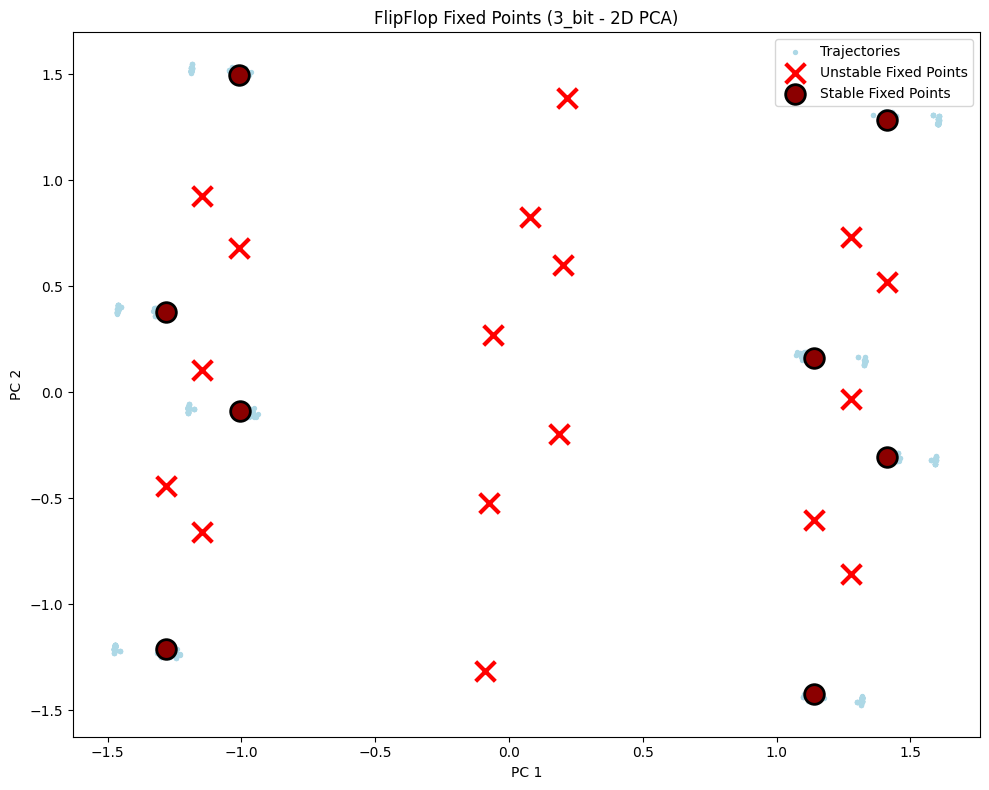

  PCA explained variance: [0.46209928 0.27972662 0.25745255]
  Total variance explained: 99.93%


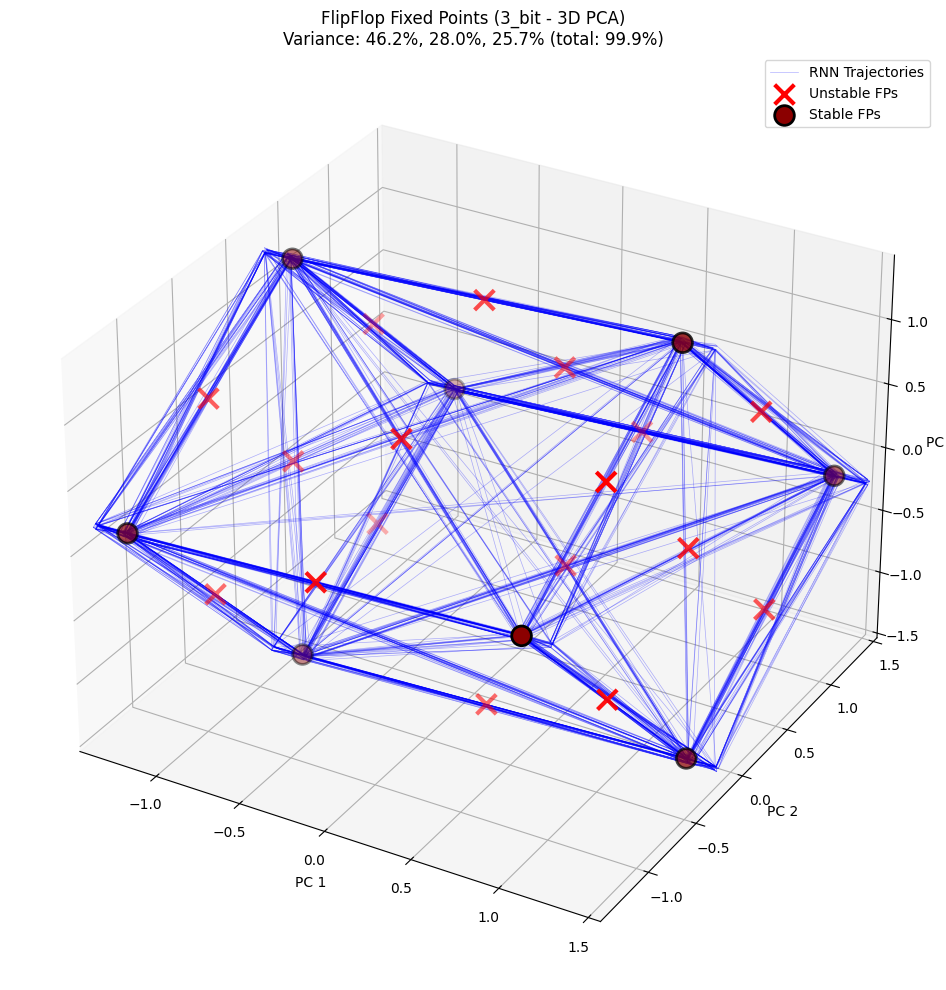


--- Analysis complete ---


In [8]:
# Print results
print("\n--- Fixed Point Analysis Results ---")
unique_fps.print_summary()

if unique_fps.n > 0:
    print(f"\nDetailed Fixed Point Information (Top 10):")
    print(f"{'#':<4} {'q-value':<12} {'Stability':<12} {'Max |eig|':<12}")
    print("-" * 45)
    for i in range(min(10, unique_fps.n)):
        stability_str = "Stable" if unique_fps.is_stable[i] else "Unstable"
        max_eig = np.abs(unique_fps.eigval_J_xstar[i, 0])
        print(
            f"{i + 1:<4} {unique_fps.qstar[i]:<12.2e} {stability_str:<12} {max_eig:<12.4f}"
        )

    # Visualize fixed points - 2D
    config_2d = PlotConfig(
        title=f"FlipFlop Fixed Points ({config_name} - 2D PCA)",
        xlabel="PC 1", ylabel="PC 2", figsize=(10, 8),
        show=True
    )
    plot_fixed_points_2d(unique_fps, hiddens_np, config=config_2d)

    # Visualize fixed points - 3D
    config_3d = PlotConfig(
        title=f"FlipFlop Fixed Points ({config_name} - 3D PCA)",
        figsize=(12, 10), 
        show=True
    )
    plot_fixed_points_3d(
        unique_fps, hiddens_np, config=config_3d,
        plot_batch_idx=list(range(30)), plot_start_time=10
    )

print("\n--- Analysis complete ---")

In [9]:
import matplotlib.pyplot as plt

def run_flipflop_analysis(config_name, seed=42):
    """Run complete analysis pipeline for a single configuration"""
    config = TASK_CONFIGS[config_name]
    n_bits = config["n_bits"]
    n_hidden = config["n_hidden"]
    n_trials_train = config["n_trials_train"]
    n_inits = config["n_inits"]
    
    # Set random seeds
    np.random.seed(seed)
    random.seed(seed)
    
    print(f"\n{'='*60}")
    print(f"Configuration: {config_name} ({n_bits} bits, {n_hidden} hidden units)")
    print(f"{'='*60}")
    
    # Generate data
    data_gen = FlipFlopData(n_bits=n_bits, n_time=64, p=0.5, random_seed=seed)
    train_data = data_gen.generate_data(n_trials_train)
    valid_data = data_gen.generate_data(128)
    test_data = data_gen.generate_data(128)
    
    # Create and train model
    rnn = FlipFlopRNN(n_inputs=n_bits, n_hidden=n_hidden, 
                      n_outputs=n_bits, rnn_type="tanh", seed=seed)
    
    checkpoint_path = f"flipflop_rnn_{config_name}_checkpoint.msgpack"
    if not load_checkpoint(rnn, checkpoint_path):
        print(f"Training model...")
        train_flipflop_rnn(rnn, train_data, valid_data,
                          learning_rate=0.08, batch_size=128,
                          max_epochs=500, min_loss=1e-4, print_every=50)
    else:
        print(f"Loaded model from checkpoint: {checkpoint_path}")
    
    # Get hidden state trajectory
    inputs_jax = jnp.array(test_data["inputs"])
    outputs, hiddens = rnn(inputs_jax)
    hiddens_np = np.array(hiddens)
    
    # Fixed point analysis
    finder = FixedPointFinder(
        rnn, method="joint", max_iters=5000, lr_init=0.02,
        tol_q=1e-4, final_q_threshold=1e-6, tol_unique=1e-2,
        do_compute_jacobians=True, do_decompose_jacobians=True,
        outlier_distance_scale=10.0, verbose=True, super_verbose=False,
    )
    
    constant_input = np.zeros((1, n_bits), dtype=np.float32)
    unique_fps, _ = finder.find_fixed_points(
        state_traj=hiddens_np, inputs=constant_input,
        n_inits=n_inits, noise_scale=0.4,
    )
    
    return unique_fps, hiddens_np, config_name

# Store results for all configurations
all_results = {}
for cfg in ["2_bit", "3_bit", "4_bit"]:
    unique_fps, hiddens_np, name = run_flipflop_analysis(cfg, seed=43)
    all_results[cfg] = {"fps": unique_fps, "hiddens": hiddens_np}
    
    # Print summary
    n_stable = np.sum(unique_fps.is_stable) if unique_fps.n > 0 else 0
    expected = 2 ** int(cfg[0])
    print(f"\nResults: Found {unique_fps.n} fixed points, {n_stable} stable (expected: {expected})")


Configuration: 2_bit (2 bits, 3 hidden units)
Training model...

Training FlipFlop RNN (Using brainpy optimizer)

Training parameters:
  Batch size: 128
  Learning rate:0.080000 (Fixed)
Epoch    0: train_loss = 0.933466, valid_loss = 0.676156
Epoch   50: train_loss = 0.000569, valid_loss = 0.000562
Epoch  100: train_loss = 0.000369, valid_loss = 0.000366
Epoch  150: train_loss = 0.000271, valid_loss = 0.000268
Epoch  200: train_loss = 0.000210, valid_loss = 0.000208
Epoch  250: train_loss = 0.000169, valid_loss = 0.000168
Epoch  300: train_loss = 0.000139, valid_loss = 0.000138
Epoch  350: train_loss = 0.000116, valid_loss = 0.000115

Reached target loss 1.00e-04 at epoch 395

Training Complete!
Final training loss: 0.000100
Final validation loss: 0.000099
Total epochs: 396

Searching for fixed points from 1024 initial states.

	Finding fixed points via joint optimization.


/var/folders/x0/_jqxxbbn0rsdn6b4h6fxbrjr0000gn/T/ipykernel_3897/1594189833.py:52: UserWarning: Joint optimization with n_inits=1024 may be inefficient and use excessive memory. Consider using sequential optimization or reducing n_inits.
  unique_fps, _ = finder.find_fixed_points(


	Optimization complete to desired tolerance.
		170 iters, q = 9.62e-08 +/- 2.84e-06, dq = 1.36e-07 +/- 4.32e-06, lr = 1.63e-02, avg iter time = 7.56e-03 sec
	Identified 9 unique fixed points.
	Computing recurrent Jacobian at 9 unique fixed points.
	Computing input Jacobian at 9 unique fixed points.
Decomposing 9 Jacobians...
Found 4 stable and 5 unstable fixed points.
	Applying final q-value filter (q < 1.0e-06)...
		9 high-quality fixed points remain.
	Fixed point finding complete.


Results: Found 9 fixed points, 4 stable (expected: 4)

Configuration: 3_bit (3 bits, 4 hidden units)
Training model...

Training FlipFlop RNN (Using brainpy optimizer)

Training parameters:
  Batch size: 128
  Learning rate:0.080000 (Fixed)
Epoch    0: train_loss = 0.917904, valid_loss = 0.676378
Epoch   50: train_loss = 0.000278, valid_loss = 0.000279
Epoch  100: train_loss = 0.000161, valid_loss = 0.000163
Epoch  150: train_loss = 0.000116, valid_loss = 0.000117

Reached target loss 1.00e-04 at epoch 18

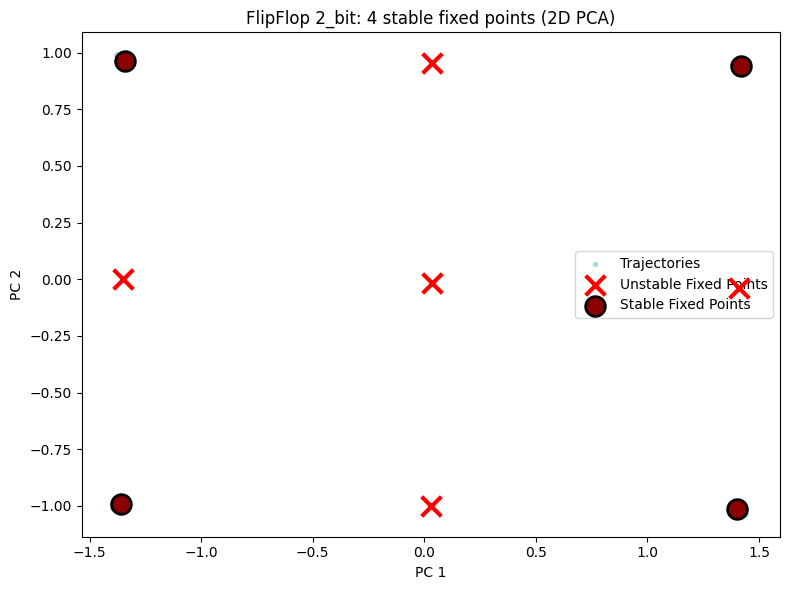

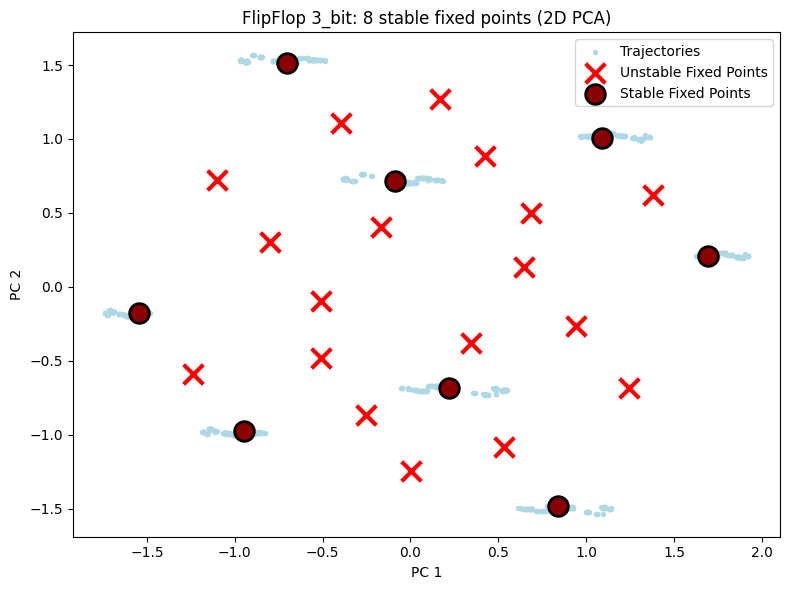

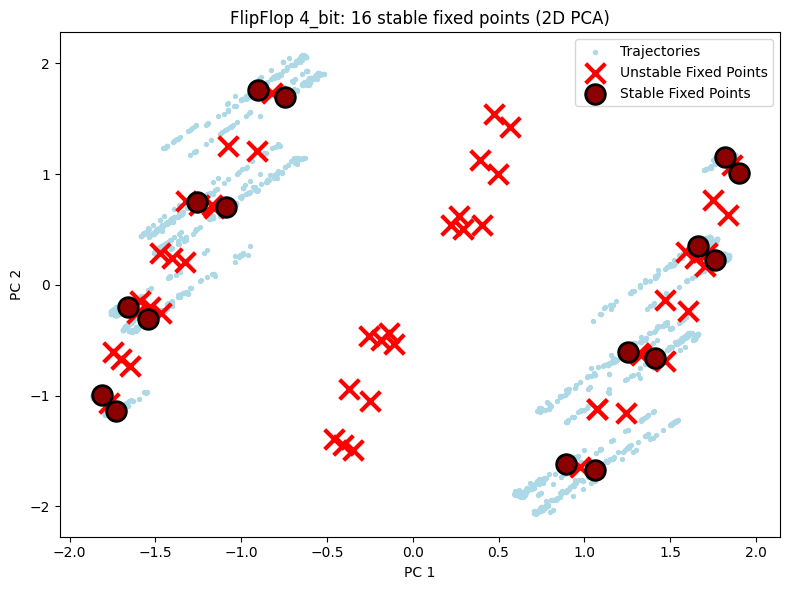

In [10]:
# 2D visualization - display each configuration separately
for cfg in ["2_bit", "3_bit", "4_bit"]:
    result = all_results[cfg]
    unique_fps = result["fps"]
    hiddens_np = result["hiddens"]
    
    n_bits = int(cfg[0])
    n_stable = np.sum(unique_fps.is_stable) if unique_fps.n > 0 else 0
    
    config_2d = PlotConfig(
        title=f"FlipFlop {cfg}: {n_stable} stable fixed points (2D PCA)",
        xlabel="PC 1", ylabel="PC 2",
        figsize=(8, 6),
        show=True
    )
    
    plot_fixed_points_2d(unique_fps, hiddens_np, config=config_2d)

  PCA explained variance: [6.6613883e-01 3.3384740e-01 1.3795699e-05]
  Total variance explained: 100.00%


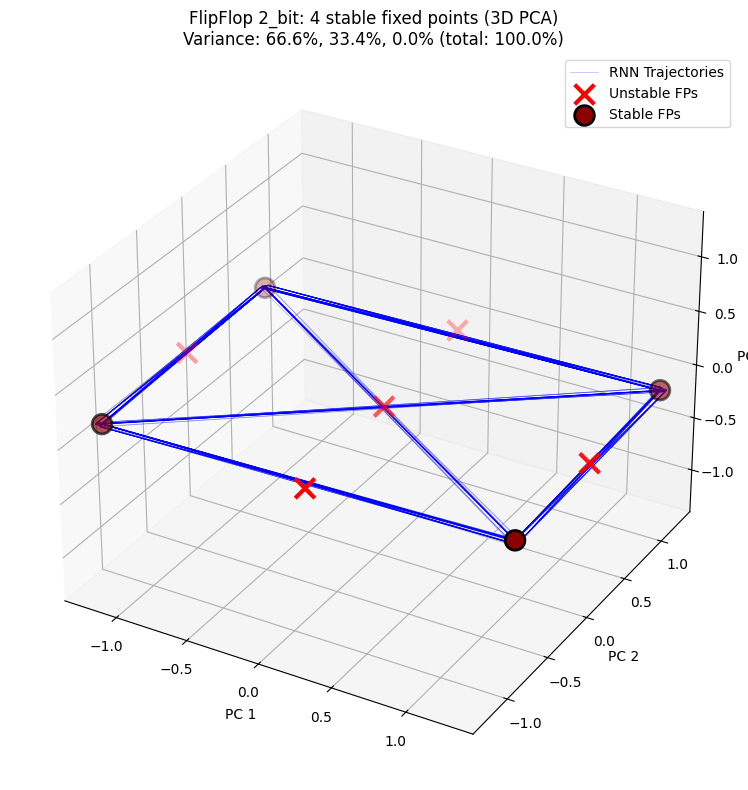

  PCA explained variance: [0.37013304 0.3110425  0.3062212 ]
  Total variance explained: 98.74%


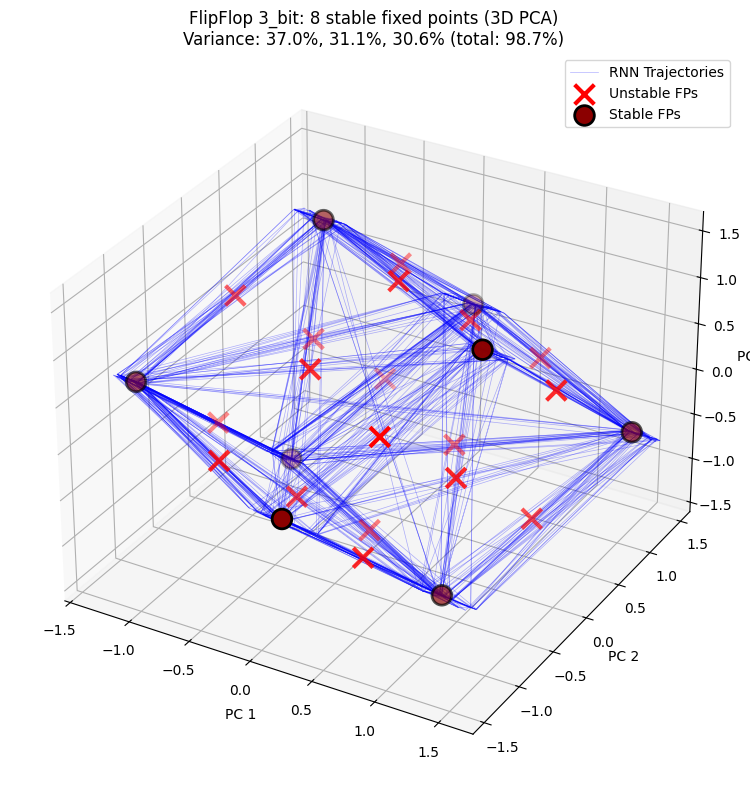

  PCA explained variance: [0.3934802  0.22392422 0.18720938]
  Total variance explained: 80.46%


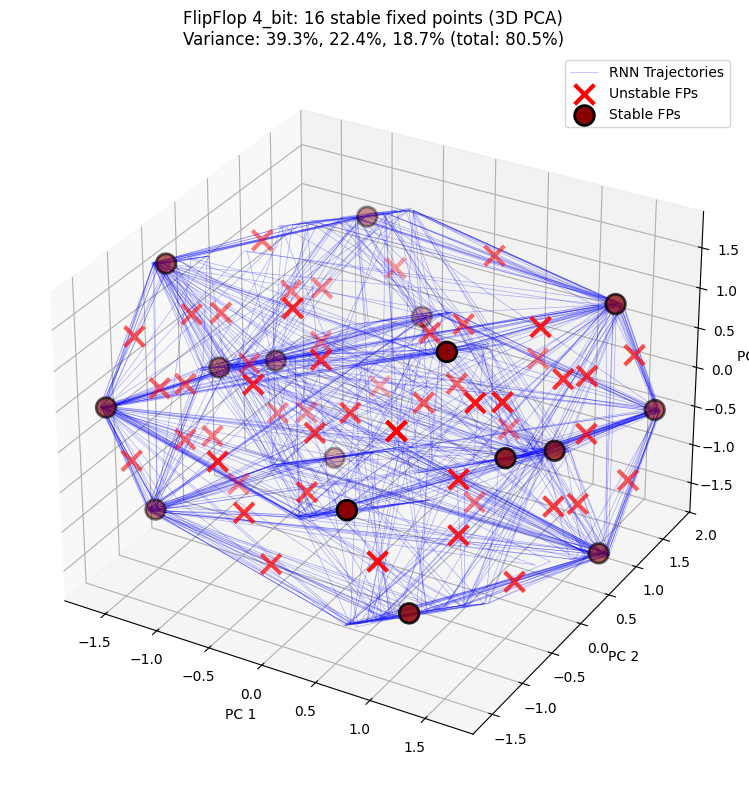

In [11]:
# 3D visualization - display each configuration separately
for cfg in ["2_bit", "3_bit", "4_bit"]:
    result = all_results[cfg]
    unique_fps = result["fps"]
    hiddens_np = result["hiddens"]
    
    n_bits = int(cfg[0])
    n_stable = np.sum(unique_fps.is_stable) if unique_fps.n > 0 else 0
    
    config_3d = PlotConfig(
        title=f"FlipFlop {cfg}: {n_stable} stable fixed points (3D PCA)",
        figsize=(10, 8),
        show=True
    )
    
    plot_fixed_points_3d(
        unique_fps, hiddens_np, config=config_3d,
        plot_batch_idx=list(range(20)), plot_start_time=10
    )